<a href="https://colab.research.google.com/github/freddiebermingham/Testing-Computational-Hypotheses-of-Word-and-Face-Recognition/blob/main/Shared7.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
from torchvision.utils import make_grid
import os

import numpy as np
import pandas as pd
import seaborn as sn
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
%matplotlib inline

from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [ ]:
transform = transforms.ToTensor()

In [ ]:
train_data = datasets.ImageFolder(('/content/gdrive/MyDrive/WF/train'), transform=transform)
test_data = datasets.ImageFolder(('/content/gdrive/MyDrive/WF/test'), transform=transform)

torch.manual_seed(42)
train_loader = DataLoader(train_data, batch_size=10, shuffle=True)
test_loader = DataLoader(test_data, batch_size=10, shuffle=True)

class_names = train_data.classes
labels = train_data.targets

print(class_names)
print(f'Training images available: {len(train_data)}')
print(f'Testing images available:  {len(test_data)}')

['Aidan_Turner', 'Ashley_Rickards', 'Christina_Hendricks', 'Christine_Lahti', 'Cillian_Murphy', 'Dawn_French', 'Jacqueline_MacInnes_Wood', 'Kari_Matchett', 'Martha_Plimpton', 'Rowan_Atkinson', 'cash ', 'cats', 'fact', 'foot', 'heat', 'holt', 'lots', 'safe', 'soft', 'tell']
Training images available: 9004
Testing images available:  1600


In [ ]:
train_data.classes

['Aidan_Turner',
 'Ashley_Rickards',
 'Christina_Hendricks',
 'Christine_Lahti',
 'Cillian_Murphy',
 'Dawn_French',
 'Jacqueline_MacInnes_Wood',
 'Kari_Matchett',
 'Martha_Plimpton',
 'Rowan_Atkinson',
 'cash ',
 'cats',
 'fact',
 'foot',
 'heat',
 'holt',
 'lots',
 'safe',
 'soft',
 'tell']

In [ ]:
torch.manual_seed(600)  

train_loader = DataLoader(train_data, batch_size=10, shuffle=True)
test_loader = DataLoader(test_data, batch_size=10, shuffle=False)

Label: [   18     4     4     4    17    18     9     9    16     9]
Class:  soft Cillian_Murphy Cillian_Murphy Cillian_Murphy safe soft Rowan_Atkinson Rowan_Atkinson lots Rowan_Atkinson


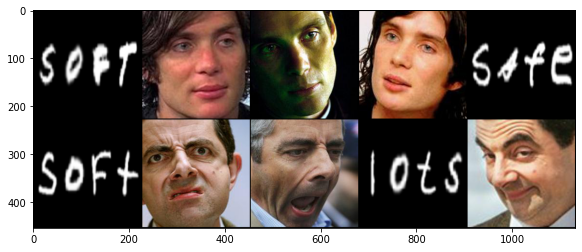

In [ ]:
np.set_printoptions(formatter=dict(int=lambda x: f'{x:5}'))

for images,labels in train_loader: 
    break

print('Label:', labels.numpy())
print('Class: ', *np.array([class_names[i] for i in labels]))


im = make_grid(images, nrow=5) 
plt.figure(figsize=(10,4))
plt.imshow(np.transpose(im.numpy(), (1, 2, 0)));

In [ ]:
class ConvolutionalNetwork(nn.Sequential):
    def __init__(self):
        super(ConvolutionalNetwork, self).__init__()
        self.layer1 = nn.Sequential(
            nn.Conv2d(3, 48, 3, 1),
            nn.ReLU(),
            nn.MaxPool2d(2,2),
            nn.Conv2d(48, 24, 3, 1),
            nn.ReLU(),
            nn.MaxPool2d(2,2),
            nn.Conv2d(24, 48, 3, 1),
            nn.ReLU(),
            nn.MaxPool2d(2,2),
            nn.Conv2d(48, 64, 3, 1),
            nn.ReLU(),
            nn.MaxPool2d(2,2),
            nn.Conv2d(64, 64, 3, 1),
            nn.ReLU(),
            nn.MaxPool2d(2,2))
         
        self.fc = nn.Sequential(
            nn.Linear(5*5*64, 240),
            nn.ReLU(),
            nn.Linear(240,20))
        

    def forward(self, X):
        X = self.layer1(X)
        
        X = X.view(-1, 5*5*64)
        
        X = self.fc(X)
        
        return F.log_softmax(X, dim=1)

In [ ]:
torch.manual_seed(600)
model = ConvolutionalNetwork()
model

ConvolutionalNetwork(
  (layer1): Sequential(
    (0): Conv2d(3, 48, kernel_size=(3, 3), stride=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(48, 24, kernel_size=(3, 3), stride=(1, 1))
    (4): ReLU()
    (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(24, 48, kernel_size=(3, 3), stride=(1, 1))
    (7): ReLU()
    (8): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (9): Conv2d(48, 64, kernel_size=(3, 3), stride=(1, 1))
    (10): ReLU()
    (11): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (12): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1))
    (13): ReLU()
    (14): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (fc): Sequential(
    (0): Linear(in_features=1600, out_features=240, bias=True)
    (1): ReLU()
    (2): Linear(in_features=240, out_features=20, bi

In [ ]:
def count_parameters(model):
    params = [p.numel() for p in model.parameters() if p.requires_grad]
    for item in params:
        print(f'{item:>6}')
    print(f'______\n{sum(params):>6}')

In [ ]:
count_parameters(model)

  1296
    48
 10368
    24
 10368
    48
 27648
    64
 36864
    64
384000
   240
  4800
    20
______
475852


In [ ]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

In [ ]:
import time
start_time = time.time()

epochs = 10
train_losses = []
test_losses = []
train_correct = []
test_correct = []

for i in range(epochs):
    trn_corr = 0
    tst_corr = 0
    
    # training batches
    for b, (X_train, y_train) in enumerate(train_loader):
        b+=1
        
        y_pred = model(X_train)
        loss = criterion(y_pred, y_train)
 
        # Tally number of correct predictions
        predicted = torch.max(y_pred.data, 1)[1]
        batch_corr = (predicted == y_train).sum()
        trn_corr += batch_corr
        
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        # results
        if b%100 == 0:
            print(f'epoch: {i:2}  batch: {b:4} [{10*b:6}/9000]  loss: {loss.item():10.8f}  \
accuracy: {trn_corr.item()*100/(10*b):7.3f}%  Duration: {time.time() - start_time:.0f} seconds')
        
    train_losses.append(loss)
    train_correct.append(trn_corr)
        
    # testing batches
    with torch.no_grad():
        for b, (X_test, y_test) in enumerate(test_loader):

            
            y_val = model(X_test)

            # Tally number of correct predictions
            predicted = torch.max(y_val.data, 1)[1] 
            tst_corr += (predicted == y_test).sum()
            
    loss = criterion(y_val, y_test)
    test_losses.append(loss)
    test_correct.append(tst_corr)
        
print(f'\nDuration: {time.time() - start_time:.0f} seconds')

epoch:  0  batch:  100 [  1000/9000]  loss: 2.29699183  accuracy:  11.200%  Duration: 370 seconds
epoch:  0  batch:  200 [  2000/9000]  loss: 1.31280637  accuracy:  18.450%  Duration: 739 seconds
epoch:  0  batch:  300 [  3000/9000]  loss: 1.02806437  accuracy:  31.300%  Duration: 1108 seconds
epoch:  0  batch:  400 [  4000/9000]  loss: 1.33127367  accuracy:  40.225%  Duration: 1474 seconds
epoch:  0  batch:  500 [  5000/9000]  loss: 0.77957118  accuracy:  46.060%  Duration: 1839 seconds
epoch:  0  batch:  600 [  6000/9000]  loss: 0.96286744  accuracy:  50.333%  Duration: 2206 seconds
epoch:  0  batch:  700 [  7000/9000]  loss: 0.79856902  accuracy:  53.914%  Duration: 2572 seconds
epoch:  0  batch:  800 [  8000/9000]  loss: 1.29606318  accuracy:  56.737%  Duration: 2941 seconds
epoch:  0  batch:  900 [  9000/9000]  loss: 0.66094601  accuracy:  59.189%  Duration: 3305 seconds
epoch:  1  batch:  100 [  1000/9000]  loss: 0.32563677  accuracy:  81.600%  Duration: 3905 seconds
epoch:  1  b

In [ ]:
print(test_correct)
print()
print(f'Test accuracy: {test_correct[-1].item()*100/1600:.3f}%')

[tensor(1356), tensor(1432), tensor(1482), tensor(1491), tensor(1508), tensor(1502), tensor(1524), tensor(1521), tensor(1525), tensor(1495)]

Test accuracy: 93.438%


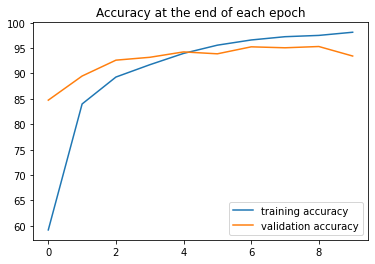

In [ ]:
plt.plot([t/90 for t in train_correct], label='training accuracy')
plt.plot([t/16 for t in test_correct], label='validation accuracy')
plt.title('Accuracy at the end of each epoch')
plt.legend();

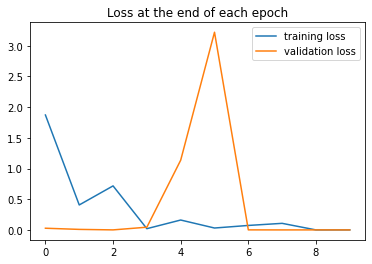

In [ ]:
plt.plot(train_losses, label='training loss')
plt.plot(test_losses, label='validation loss')
plt.title('Loss at the end of each epoch')
plt.legend();

In [ ]:
torch.save(model.state_dict(), '/content/gdrive/MyDrive/SHARED7.pt')